# Projecting Food Insecurity Rates in the US by County
## Feature Selection & Modeling Process
### Flatiron School Data Science Capstone<br>By Khyatee Desai

This notebook contains the feature selection and modeling process to predict food insecurity rates based on a number of features, both from the original datasets, as well as engineered features which were created in [feature_engineering.ipynb](feature_engineering.ipynb).

In [856]:
import pandas as pd
import numpy as np
import geopandas as gpd
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statistics as stats
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import sklearn
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from keras.losses import mean_squared_error
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras import backend as K
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import pickle
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
import sys
sys.path.insert(0, '../src/')
from functions import *

### Import cleaned dataset

In [807]:
# fully cleaned data with engineered features
with open('../pickled/feature_engineered_data.pickle', "rb") as input_file:
    df = pickle.load(input_file) 
    
# remove features not needed for modeling
df.drop([ 'coc_number','Low Threshold Type', 'High Threshold Type','State', 'County', 'State/County'],axis=1, inplace=True)
df.head(3)

,FIPS,Rent,Year,Houseless_rate,Sheltered_rate,Unsheltered_rate,hh_med_income,percent_hh_poverty,hh_avg_size,num_hh,TOT_POP,FI Rate,Cost Per Meal,Num_wholesale,Num_restaraunts,Num_grocery,Total_workforce,Employed,Unemployed,Unemployment_rate,Percent_male,Percent_female,Percent_white,Percent_Black,Percent_native,Percent_asian,Percent_pacific,Percent_latinX,Percent_PoC,Percent_working,Total_food_retail,Food_retail_per_person,Percent_disabled,Percent_hs_grad,Percent_bachelors,Percent_grad_degree,Percent_priv_health,Percent_public_health,Percent_no_health,Percent_65+,Percent_non_citizen,Percent_hh_no_vehicle,Percent_hh_SNAP,Rent^2,Rent^3,Houseless_rate^2,Houseless_rate^3,Sheltered_rate^2,Sheltered_rate^3,Unsheltered_rate^2,Unsheltered_rate^3,TOT_POP^2,TOT_POP^3,Cost Per Meal^2,Cost Per Meal^3,Num_wholesale^2,Num_wholesale^3,Num_restaraunts^2,Num_restaraunts^3,Num_grocery^2,Num_grocery^3,Unemployment_rate^2,Unemployment_rate^3,Percent_male^2,Percent_male^3,Percent_female^2,Percent_female^3,Percent_white^2,Percent_white^3,Percent_Black^2,Percent_Black^3,Percent_native^2,Percent_native^3,Percent_asian^2,Percent_asian^3,Percent_pacific^2,Percent_pacific^3,Percent_latinX^2,Percent_latinX^3,Percent_working^2,Percent_working^3,Total_food_retail^2,Total_food_retail^3,Food_retail_per_person^2,Food_retail_per_person^3,Percent_disabled^2,Percent_disabled^3,Percent_hs_grad^2,Percent_hs_grad^3,Percent_bachelors^2,Percent_bachelors^3,Percent_grad_degree^2,Percent_grad_degree^3,Percent_priv_health^2,Percent_priv_health^3,Percent_public_health^2,Percent_public_health^3,Percent_no_health^2,Percent_no_health^3,Percent_65+^2,Percent_65+^3,Percent_non_citizen^2,Percent_non_citizen^3,Percent_hh_no_vehicle^2,Percent_hh_no_vehicle^3,Percent_hh_SNAP^2,Percent_hh_SNAP^3,percent_hh_poverty^2,percent_hh_poverty^3,hh_avg_size^2,hh_avg_size^3,num_hh^2,num_hh^3,hh_med_income^2,hh_med_income^3,Unemployment_rate_X_Percent_Black,Unemployment_rate_X_Percent_white,Unemployment_rate_X_Percent_latinX,Houseless_rate_X_Sheltered_rate,Sheltered_rate_X_Percent_grad_degree,Percent_Black_X_Percent_hh_SNAP,Percent_latinX_X_hh_med_income,Cost Per Meal_X_Percent_Black,Unemployment_rate_X_hh_avg_size,Percent_white_X_Percent_hh_SNAP,Rent_X_Unemployment_rate,Percent_Black_X_Percent_grad_degree,Percent_pacific_X_Percent_hs_grad,Percent_latinX_X_Percent_hh_SNAP,Unemployment_rate_X_Percent_non_citizen,Percent_white_X_Percent_grad_degree,Percent_latinX_X_percent_hh_poverty,TOT_POP_X_Percent_latinX,Unemployment_rate_X_Percent_female,Unemployment_rate_X_Percent_male,Percent_pacific_X_Percent_public_health,Percent_Black_X_Percent_hs_grad,Percent_latinX_X_num_hh,Rent_X_Percent_Black,Num_grocery_X_num_hh,Houseless_rate_X_Percent_pacific,Percent_white_X_percent_hh_poverty,Percent_white_X_Percent_priv_health,Percent_white_X_Percent_pacific,Unemployment_rate_X_Percent_hs_grad,Unemployment_rate_X_Percent_disabled,Percent_white_X_Percent_no_health,Percent_female_X_Percent_hs_grad,Sheltered_rate_X_Percent_working,Percent_Black_X_Percent_no_health,Percent_Black_X_percent_hh_poverty,Percent_pacific_X_Percent_disabled,Cost Per Meal_X_Percent_white,Percent_pacific_X_Percent_65+,Sheltered_rate_X_Percent_no_health,TOT_POP_X_Num_grocery,Percent_Black_X_hh_med_income,Percent_Black_X_Percent_priv_health,Percent_hs_grad_X_hh_avg_size,Sheltered_rate_X_Percent_pacific,Unemployment_rate_X_Percent_hh_SNAP,Percent_latinX_X_Percent_priv_health,Total_food_retail_X_num_hh,Houseless_rate_X_Percent_grad_degree,Percent_pacific_X_Percent_hh_SNAP,log_Rent,log_Houseless_rate,log_Sheltered_rate,log_Unsheltered_rate,log_TOT_POP,log_Cost Per Meal,log_Num_wholesale,log_Num_restaraunts,log_Num_grocery,log_Unemployment_rate,log_Percent_male,log_Percent_female,log_Percent_white,log_Percent_Black,log_Percent_native,log_Percent_asian,log_Percent_pacific,log_Percent_latinX,log_Percent_working,log_Total_food_retail,log_Food_retail_per_person,log_Percent_disabled,log_Percent_hs_grad,log_Percent_bachelors,log_Percent_grad_degree,l

# Linear Regression Models
## Model 1: All Features
The first model is a simple linear regression model that trains on data from years 2010-2018, uses *all* engineered features created in feature_engineering.ipynb.

In [808]:
df.Year.value_counts()

2019    3518
2018    3406
2017    3395
2014    3386
2016    3386
2020    3385
2015    3384
2010    3279
2009    3239
2011    1785
2012    1785
2013    1785
Name: Year, dtype: int64

### Train/Test Split
**Note:** The rent column is dropped for all models, because rent price data was only available for major metropolitan areas, and therefore retaining the column would require dropping a large majority of rows in order for the models to run. This decision should not significantly impact the performance of the models, given that the relationship between rent and the FI rates is not very strong, as was determined through the EDA process.

In [809]:
# Limit the year and drop rows containing null values in either of the specified columns.
df_model = df[df.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017'
                ,'2018'])].dropna(subset=['Num_wholesale','Houseless_rate','Percent_disabled','hh_med_income'])

# drop the Rent column, and all engineers features using the rent column
for col in df_model.columns:
    if 'Rent' in col:
        df_model.drop(col,axis=1,inplace=True)

# isolate target variable and features
y = df_model['FI Rate']
X = df_model.drop([ 'FIPS','FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2)

In [810]:
df_model.shape

(13305, 200)

### Model 1
The model uses 13305 observations (seen above) and uses Cross Validation with 5 folds.<br>It produces a Train/Test R-Squared value of about 0.60, an average Train/Test RMSE of 0.028, and a mean cross validation R-squared of -6.71.

In [811]:
# Instantiate Linear Regression model
linreg_1 = LinearRegression()
linreg_1.fit(X_train, y_train)
y_train_pred = linreg_1.predict(X_train)
y_test_pred = linreg_1.predict(X_test)

# R2 of training and test set
print('R2 Train:',linreg_1.score(X_train, y_train))
print('R2 Test:',linreg_1.score(X_test, y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)),'\n')

scores =cross_val_score(linreg_1, X, y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.598184397851734
R2 Test: 0.5990132981939256
RMSE Train: 0.02703977467847216
RMSE Test: 0.02735717503243032 

CV Scores: [-35.72401095   0.54035841   0.53336154   0.633015     0.45586088]
Mean CV Score: -6.712283024774531


## Linear Regression Model 2: Remove Outliers
The EDA notebook included a section on inspecting which features have the largest outliers, using box and whisker plots. The following cell focuses on the features with highest outliers: `'TOT_POP'`, `'num_hh'`, `'Total_workforce'`, `'Employed'`, `'Unemployed'`, `'Total_workforce'`, and `'Total_food_retail'`

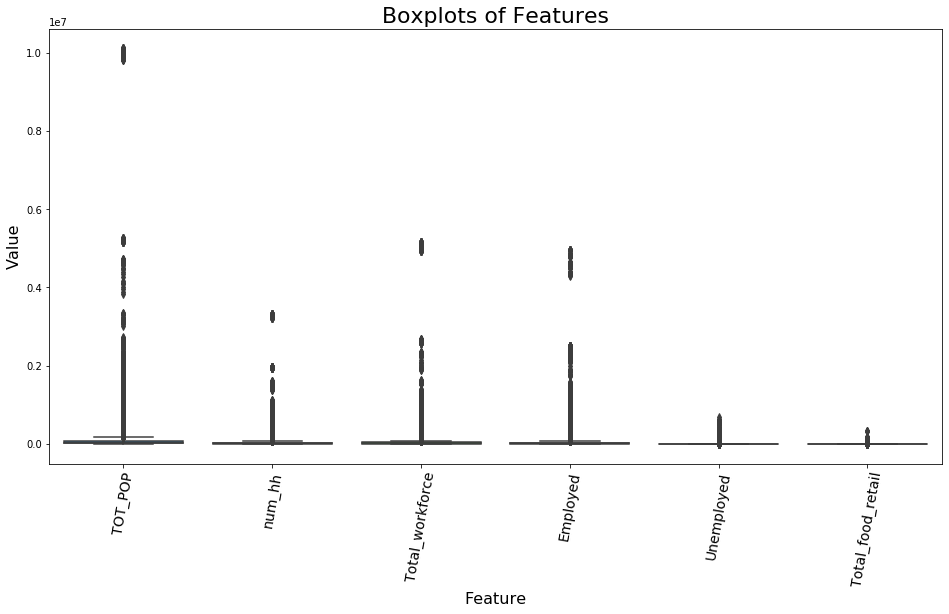

In [812]:
features = ['TOT_POP', 'num_hh', 'Total_workforce', 'Employed', 'Unemployed', 'Total_food_retail']

# create boxplot for each feature with outliers
plt.figure(figsize=(16, 8));
sns.boxplot(data= df.loc[:,features]);
plt.title('Boxplots of Features', fontdict={'fontsize':22});
plt.ylabel('Value', fontdict={'fontsize':16});
plt.xlabel('Feature', fontdict={'fontsize':16});
plt.xticks(rotation=80,fontsize=14);


### Remove Outliers
The following cell iterates over each feature with outliers, and if the feature has obsrvations *greater* than +/- 2 standard deviations of the mean, it reduces outliers to +/- 2 standard deviations from the mean of that feature.

In [813]:
# Bring outliers down/up to 2 standard deviations from the mean 
df_out = df.copy()
for feat in features:
    abv_2_std = df_out[feat].mean()+ 2* df_out[feat].std()
    below_2_std = df_out[feat].mean()- 2* df_out[feat].std()
    conditions = [df_out[feat]>abv_2_std, df_out[feat]<below_2_std]
    choices = [abv_2_std, below_2_std]
    df_out[feat] = np.select(conditions, choices, df_out[feat])


### Visualize Again
After reducing outliers, the boxplots are visualized again:

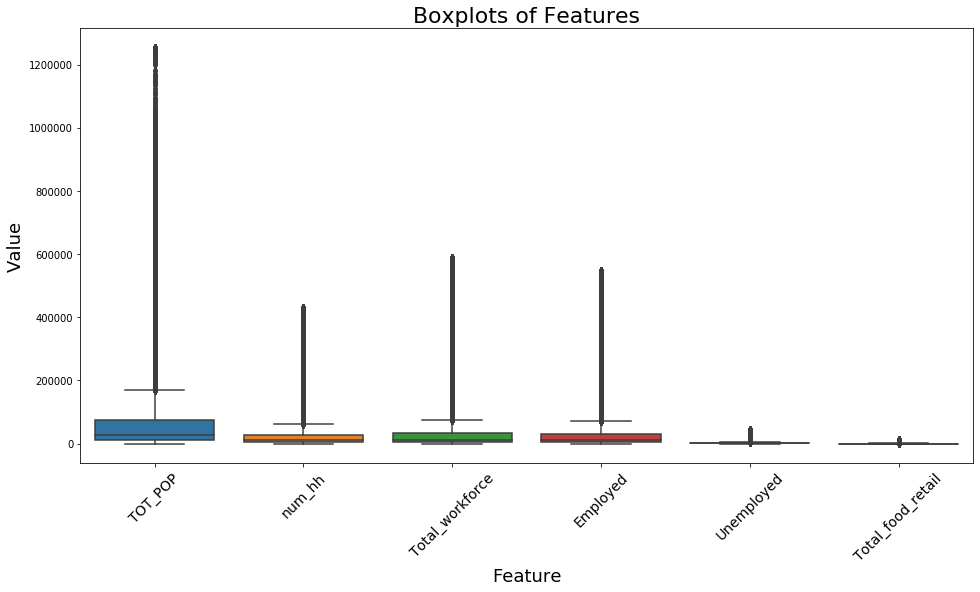

In [814]:
# create boxplot for each feature with outliers
plt.figure(figsize=(16, 8));
sns.boxplot(data= df_out[features]);
plt.title('Boxplots of Features', fontdict={'fontsize':22});
plt.ylabel('Value', fontdict={'fontsize':18});
plt.xlabel('Feature', fontdict={'fontsize':18});
plt.xticks(rotation=45,fontsize=14);

### Train/Test Split 2
Perform train/test split similarly as above, after massive outliers have been reduced

In [820]:
# Limit the year and drop null values
df_model = df_out[df_out.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017'
                 ,'2018'])].dropna(subset=['Num_wholesale','Percent_disabled','Houseless_rate','hh_med_income'])
for col in df_model.columns:
    if 'Rent' in col:
        df_model.drop(col,axis=1,inplace=True)
        
# isolate target variable and features
y = df_model['FI Rate']
X = df_model.drop(['FIPS', 'FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Model 2
Re-run the model using the same process as model 1, now on data with reduced outliers.<br>
Model 2 produces a slightly better Train/Test R-Squared value of about 0.50, a worse average Train/Test RMSE of about 0.03, and a much lower mean cross validation score of -16.31.<br>**For this reason, outliers are retained in the following models.**

In [821]:
# Instantiate Linear Regression model
linreg_2 = LinearRegression()
linreg_2.fit(X_train, y_train)
y_train_pred = linreg_2.predict(X_train)
y_test_pred = linreg_2.predict(X_test)

# R2 of training and test set
print('R2 Train:',linreg_2.score(X_train, y_train))
print('R2 Test:',linreg_2.score(X_test, y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)))

scores =cross_val_score(linreg_2, X, y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.5072029003627818
R2 Test: 0.5141102698128598
RMSE Train: 0.030043506114981054
RMSE Test: 0.029747404464399833
CV Scores: [-82.00923088   0.52981109   0.53699172  -0.31065613  -0.27715724]
Mean CV Score: -16.306048286091762


# Feature Selection
The following processes use a few different feature selection methods to determine the optimal features for the MVP model
### Train/Test Split 3 
Need to do this again to add outliers back in

In [822]:
# create df_model again, with outliers included this time
df_model = df[df.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017',
                    '2018'])].dropna(subset=['Num_wholesale','Percent_disabled','Houseless_rate','hh_med_income'])
for col in df_model.columns:
    if 'Rent' in col:
        df_model.drop(col,axis=1,inplace=True)
        
# isolate target variable and features
y = df_model['FI Rate']
X = df_model.drop(['FIPS', 'FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Multicollinearity 
Multicollinearity can create noise within the data. A heatmap is produced from correlation matrix in the [EDA.ipynb](EDA.ipynb) notebook, which highlights that houseless rate, sheltered/unsheltered rates, and all of the race-related features are highly correlated with one another. The following cells explain the correlation between feature pairs even more:
### Inspect correlation between each feature pair
The correlation matrix is reformatted to show the correlation between each feature pair - we see that demographics features, employment-related features, and houselessness-related features are all highly correlated, which is to be expected.

In [823]:
# reformat the correlation matrix and output top 15 pairs
corr=df_model.iloc[:,1:].corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr['pairs'] = list(zip(corr.level_0, corr.level_1))
corr.drop(columns=['level_1', 'level_0'], inplace = True)
corr.columns = ['correlation', 'pairs']
corr.drop_duplicates(inplace=True)
corr[(corr.correlation >0.95) & (corr.correlation <1.0)][:15]

,correlation,pairs
11987,0.999901,"(Percent_female^2, log_Percent_male)"
32959,0.999901,"(log_Percent_male, Percent_female^2)"
33154,0.999791,"(log_Percent_female, Percent_male^2)"
11594,0.999791,"(Percent_male^2, log_Percent_female)"
26152,0.999764,"(Num_grocery_X_num_hh, TOT_POP_X_Num_grocery)"
29288,0.999764,"(TOT_POP_X_Num_grocery, Num_grocery_X_num_hh)"
2771,0.999674,"(Employed, Total_workforce)"
2575,0.999674,"(Total_workforce, Employed)"
1392,0.999181,"(TOT_POP, Total_workforce)"
2568,0.999181,"(Total_workforce, TOT_POP)"


### Varience Inflation Factor
Variance inflation factor (VIF) helps quantifies the severity of multicollinearity in a regression model, by comparing variance of the model with different terms. High VIF scores indicate severe multicollinearity. The following cell creates a dataframe only with features that have VIF scores below 40:

In [824]:
# create a vif dataframe with all features of scores below 50
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif_features = vif[vif['VIF Factor'] <50]['features']
vif[vif['VIF Factor'] <50].head()

,VIF Factor,features
0,1.009854,Houseless_rate
1,1.091869,Sheltered_rate
2,0.990675,Unsheltered_rate
3,7.380262,hh_med_income
4,0.541568,percent_hh_poverty


## Linear Regression Model 3: Removed Multicollinear Features
Model 3 uses only features with VIF scores below 50. It performs significantly better than the prior models, with a Train/Test R-Squared value of about 0.87, a Train/Test RMSE of about 0.0154, and a much higher mean cross validation score of 0.834.


In [826]:
# Instantiate Linear Regression model
linreg_3 = LinearRegression()
linreg_3.fit(X_train[vif_features], y_train)
y_train_pred = linreg_3.predict(X_train[vif_features])
y_test_pred = linreg_3.predict(X_test[vif_features])

# R2 of training and test set
print('R2 Train:',linreg_3.score(X_train[vif_features], y_train))
print('R2 Test:',linreg_3.score(X_test[vif_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)))

scores =cross_val_score(linreg_3, X[vif_features], y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.8712382382383217
R2 Test: 0.8669478307268027
RMSE Train: 0.015395360596211185
RMSE Test: 0.015447759198685795
CV Scores: [0.89687646 0.86212112 0.80290289 0.71890274 0.88956917]
Mean CV Score: 0.8340744762563777


## Linear Regression 4: K-Best Selected Features
Model 4 uses `SelectKBest()` to determine the best k featues to use in a model. The cell below loops through a number of k values to determine the optimal one.

In [828]:
# determine optimal k with a loop 

for k in range(75,80):
    selector = SelectKBest(f_regression, k=k)
    selector.fit(X_train, y_train)
    kbest_features = X_train.columns[selector.get_support()]
    linreg = LinearRegression()
    linreg.fit(X_train[kbest_features], y_train)
    y_test_pred = linreg.predict(X_test[kbest_features])
    print(k,'\n', linreg.score(X_test[kbest_features],y_test))
    print(np.mean(cross_val_score(linreg, X[kbest_features], y, cv=5,  scoring='r2')))


75 
 0.8628187683905648
0.8425534888487001
76 
 0.8625305251976453
0.8439631344447622
77 
 0.8656455864207243
0.8413488615263109
78 
 0.8653593880629026
0.840595594341256
79 
 0.8655657722288193
0.8416361113231245


### Model 4
The best k value is determined to be 76, so model 4 is run with those features. Model 4 performs slightly better than model 3, with an average **R-squared value of .86**, an **RMSE of .0157**, and an average **cross validation score of 0.844.**

In [830]:
# run model with best k features
selector = SelectKBest(f_regression, k=76)
selector.fit(X_train, y_train)
kbest_features = X_train.columns[selector.get_support()]

linreg_4 = LinearRegression()
linreg_4.fit(X_train[kbest_features], y_train)
y_train_pred = linreg_4.predict(X_train[kbest_features])
y_test_pred = linreg_4.predict(X_test[kbest_features])

# R2 of training and test set
print('R2 Train:', linreg_4.score(X_train[kbest_features], y_train))
print('R2 Test:', linreg_4.score(X_test[kbest_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)))

# cross validation scores
scores = cross_val_score(linreg_4, X[kbest_features], y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.8662712720647685
R2 Test: 0.8625305251976453
RMSE Train: 0.015689487850618748
RMSE Test: 0.01570209671101613
CV Scores: [0.8908873  0.85566167 0.79868364 0.7839196  0.89066347]
Mean CV Score: 0.8439631344447622


## Linear Regression Model 5: Recursive Feature Elimination
Recursive feature elimination is used to iteratively remove features and rerun the model, in order to find an optimal set of features to use.
### Run RFE to retrieve set of rfe_features

In [831]:
linreg = LinearRegression()
selector = RFECV(estimator= linreg, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
selector.fit(X_train, y_train)
rfe_features = X_train.columns[selector.support_]

# Save RFE features using pickle
# with open('../pickled/rfe_features.pickle', "wb") as output_file:
#     pickle.dump(rfe_features, output_file)

### Linear Regression Model 5:
The RFE model performs slightly better than the Select K Best model, with an average **R-squared value of .89**, an **RMSE of .014**, and an average **cross validation score of 0.848**.

In [833]:
linreg_5 = LinearRegression()
linreg_5.fit(X_train[rfe_features], y_train)
y_train_pred = linreg_5.predict(X_train[rfe_features])
y_test_pred = linreg_5.predict(X_test[rfe_features])

# R2 of training and test set
print('R2 Train:',linreg_5.score(X_train[rfe_features], y_train))
print('R2 Test:',linreg_5.score(X_test[rfe_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)),'\n')

# cross validation scores
scores = cross_val_score(linreg_5, X[rfe_features], y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:', abs(np.mean(scores)))

R2 Train: 0.8975040435419228
R2 Test: 0.890080394344137
RMSE Train: 0.013735667734650684
RMSE Test: 0.014040807719953355 

CV Scores: [0.8897872  0.88287485 0.81280257 0.75315914 0.901877  ]
Mean CV Score: 0.8481001542856358


### Model Coefficients
View the ten highest coefficients alongside their corresponding features -- from the output, we see that **houseless rates**, **race**, **food access**, and **income** are the highest predictors for food insecurity, which is not suprising after doing EDA on this data.

In [836]:
sorted(list(zip(linreg_5.coef_.tolist(), X_test.columns)), reverse=True)[:10]

[(77127.10748891717, 'Unsheltered_rate^2'),
 (7635.663256958879, 'Houseless_rate'),
 (1171.7152425585991, 'Percent_hh_SNAP'),
 (670.5564721787557, 'Percent_hh_no_vehicle^2'),
 (92.76282148426314, 'Percent_white^2'),
 (59.426569287134946, 'Num_restaraunts^2'),
 (34.130545677992345, 'Percent_Black_X_hh_med_income'),
 (27.878100988037374, 'Percent_latinX_X_num_hh'),
 (13.530411868569455, 'Percent_hh_no_vehicle^3'),
 (11.319329462223823, 'Num_wholesale^3')]

# Neural Network Regressor
Keras is used to build a sequential neural network with one hidden layer
### Train/Test Split

In [837]:
# subset years and drop null rows
df_model = df[df.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017',
                    '2018'])].dropna(subset=['Num_wholesale','Percent_disabled','Houseless_rate','hh_med_income'])
for col in df_model.columns:
    if 'Rent' in col:
        df_model.drop(col,axis=1,inplace=True)
        
# isolate target variable and features
y = df_model['FI Rate']
X = df_model.drop(['FIPS', 'FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Construct the network

In [848]:

NN_2020 = Sequential()

# The Input Layer
NN_2020.add(Dense(X[rfe_features].shape[1], kernel_initializer='normal',input_dim = X[rfe_features].shape[1], activation='relu'))

# The Hidden Layers
NN_2020.add(Dense(100,activation='relu'))

# The Output Layer
NN_2020.add(Dense(1,activation='linear'))
             
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

# Compile the network
NN_model.compile(loss= root_mean_squared_error, optimizer='RMSprop',metrics=[root_mean_squared_error])
NN_2020.summary()


Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_385 (Dense)            (None, 178)               31862     
_________________________________________________________________
dense_386 (Dense)            (None, 100)               17900     
_________________________________________________________________
dense_387 (Dense)            (None, 1)                 101       
Total params: 49,863
Trainable params: 49,863
Non-trainable params: 0
_________________________________________________________________


In [849]:
## used to save model checkpoints

# checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
# checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
# callbacks_list = [checkpoint]

### Neural Network model evaluation
The neural network produces a cross validated RMSE of 0.0342, which underperforms the linear regression models

In [850]:
NN_model.fit(X[rfe_features], y, epochs=5, batch_size=10, validation_split = 0.2)


Epoch 1/5
1065/1065 [==============================] - 6s 4ms/step - loss: 0.0321 - root_mean_squared_error: 0.0321 - val_loss: 0.0327 - val_root_mean_squared_error: 0.0327
Epoch 2/5
1065/1065 [==============================] - 5s 5ms/step - loss: 0.0325 - root_mean_squared_error: 0.0325 - val_loss: 0.0322 - val_root_mean_squared_error: 0.0322
Epoch 3/5
1065/1065 [==============================] - 4s 4ms/step - loss: 0.0318 - root_mean_squared_error: 0.0318 - val_loss: 0.0332 - val_root_mean_squared_error: 0.0332
Epoch 4/5
1065/1065 [==============================] - 4s 4ms/step - loss: 0.0317 - root_mean_squared_error: 0.0317 - val_loss: 0.0334 - val_root_mean_squared_error: 0.0334
Epoch 5/5
1065/1065 [==============================] - 2s 2ms/step - loss: 0.0318 - root_mean_squared_error: 0.0318 - val_loss: 0.0342 - val_root_mean_squared_error: 0.0342


# XGBoost Regressor

In [854]:
# instantiate and fit the model
XGBModel = XGBRegressor()
XGBModel.fit(X_train[rfe_features], y_train, verbose=2)

# make predictions on train/test data
y_train_pred = XGBModel.predict(X_train[rfe_features])
y_test_pred = XGBModel.predict(X_test[rfe_features])


[14:10:03] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### XGBoost Model Evaluation
This model greatly outperforms the linear regression models, with an average Train/Test R2 of **0.91**, an average Train/Test RMSE of **0.0125**, and a cross validation RMSE of **0.0154**

In [861]:
# R2 of training and test set
print('R2 Train:',XGBModel.score(X_train[rfe_features], y_train))
print('R2 Test:',XGBModel.score(X_test[rfe_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)),'\n')

# cross validation scores
scores = cross_val_score(XGBModel, X[rfe_features], y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:', abs(np.mean(scores)))

R2 Train: 0.9195396575587936
R2 Test: 0.9021972197164853
RMSE Train: 0.0044938195224057354
RMSE Test: 0.011546554371711076 

[15:06:08] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:23] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:38] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:53] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:07:08] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CV Sc

# Random Forest Regressor

In [857]:
# Instantiate and fit the model
forest = RandomForestRegressor()
forest.fit(X_train[rfe_features],y_train)

# generate Train/Test predictions
y_train_pred = forest.predict(X_train[rfe_features])
y_test_pred = forest.predict(X_test[rfe_features])


### Random Forest Model Evaluation
The random forest model performed best of all, with an average Train/Test R2 of **0.96**, an average Train/Test RMSE of **0.008**, and a cross validation RMSE of **0.884**

In [860]:
# R2 of training and test set
print('R2 Train:',forest.score(X_train[rfe_features], y_train))
print('R2 Test:',forest.score(X_test[rfe_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)),'\n')

# cross validation scores
scores = cross_val_score(forest, X[rfe_features], y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:', abs(np.mean(scores)))

R2 Train: 0.9891019852163736
R2 Test: 0.9241052735942856
RMSE Train: 0.0044938195224057354
RMSE Test: 0.011546554371711076 

CV Scores: [0.91502994 0.91489656 0.84021644 0.81156016 0.93738054]
Mean CV Score: 0.8838167273673083


### Pickled the best performing model

In [859]:
# with open('../pickled/random_forest_model.pickle', "wb") as output_file:
#     pickle.dump(forest, output_file)

# Modeling Conclusion
The final RFE Random Forest Regressor was able to explain about **88%** of the variance in the data, based on a cross validation R2 score of **.884**, and was off on predictions by an average of **1.5%**, based on Test RMSE score of 0.015.<br>
This model, along with the best linear regression model will be further evaluated in the [predictions notebook](predictions.ipynb), and used to make predictions on unlabeled data to generate estimates for 2020 national food insecurity rates.

